- The position at which slope is reset

In [1]:
%reload_ext autoreload
%autoreload 2
import os
os.environ['MPLCONFIGDIR'] = '../config'
import pickle
import pandas as pd
import sklearn as sk
from sklearn.decomposition import *
from sklearn.cluster import *
import numpy as np
import matplotlib.pylab as plt
from matplotlib.backends.backend_pdf import PdfPages
from analysis.sparse_analysis import *
import sklearn.metrics as skmetrics
from scipy.stats import pearsonr, wilcoxon
from scipy import signal
from palettable.colorbrewer.qualitative import Paired_8 as colors
np.random.seed(0) #for reproducibility
import matplotlib as mpl
from analysis.peak_detect import *
import pickle
import pandas as pd 
import seaborn as sns
sns.set_palette("Accent")

### Load data

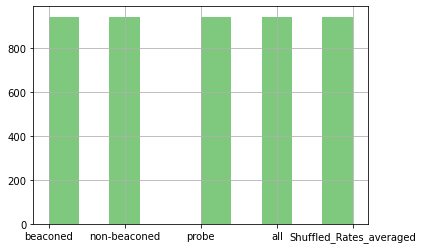

In [2]:
dfs = pd.read_csv('E:/in_vivo_vr/sarah_glm_202006/all_results_linearmodel.txt',delimiter='\t')

# Load the Sarah's RDS file directly
df = pd.read_csv('E:/in_vivo_vr/sarah_glm_202006/df_final_average_firingRate2.csv')

with open('E:/in_vivo_vr/sarah_glm_202006/aggregated_ramp_score_shuffle.pkl','rb') as f:
    df_ramp_score_shuffle = pickle.load(f)
    
with open('E:/in_vivo_vr/sarah_glm_202006/aggregated_ramp_score.pkl','rb') as f:
    df_ramp_score = pickle.load(f)
    
df_ramp_score_shuffle_all = df_ramp_score_shuffle[df_ramp_score_shuffle.trial_type=='all'].copy()
df_ramp_score_shuffle_all['trial_type'] = 'Shuffled_Rates_averaged' # so that can be merged easier later
    
df_ramp_score = df_ramp_score.append(df_ramp_score_shuffle_all)
df_ramp_score = df_ramp_score[df_ramp_score.ramp_region=='outbound']
df_ramp_score.trial_type.hist()





Data cleaning

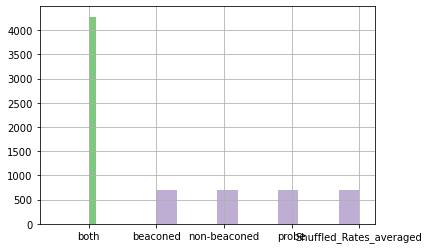

In [3]:
#Match lm results with average rate curves
df2 = df.groupby(['session_id','cluster_id','trial_type']).agg(lambda x: list(x)).reset_index()
df_merged = df2.merge(dfs, on=['session_id','cluster_id'],indicator=True)
df_merged['_merge'].hist()
df_merged = df_merged.replace({'Rates_averaged': 'beaconed',
                            'Rates_averaged_nb': 'non-beaconed',
                            'Rates_averaged_p':'probe'})
df_merged[1:3]

df_merged = df_merged[~df_merged.trial_type.str.contains('rewarded|failed')]
df_merged = df_merged.replace({'NoSlope':'Unclassified','None':'Unclassified'})

# merge with the rampscore too
df_merged = df_merged.merge(df_ramp_score,on=['session_id','cluster_id','trial_type'])
df_merged.trial_type.hist()

### Peak analysis

In [4]:
out_range = np.arange(30,110) # from 30 to  100 cm, slightly beyond the reward zone x*2-30
home_range = np.hstack([np.arange(110,199),np.arange(0,29)]) # 110 to 200, 0 to 30
all_range = np.arange(200)


dfs_agg_out_sel = peakAnalysis3(df_merged,out_range,lm_check_col='lm_result_outbound')
dfs_agg_home_sel = peakAnalysis3(df_merged,home_range,lm_check_col='lm_result_outbound')
dfs_agg_all_sel = peakAnalysis3(df_merged,all_range,lm_check_col='lm_result_outbound')

dfs_agg_out_sel.head()

,session_id,cluster_id,trial_type,pos,Average_Firing_Rate,lm_result_outbound,lm_result_homebound,lmer_result_outbound,lmer_result_homebound,_merge,...,breakpoint,fr_smooth,ramp_region,pos_bin,maxima,maxima_cm,smooth_curve,maxima_type,min_cm,max_cm
0,1124_D11_2018-11-01_11-17-22,11,beaconed,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[nan, 1.005979224345923, 1.0365395305148486, 1...",Unclassified,Unclassified,P,PA,both,...,"[30, 66]","[1.6602558382387966, 1.4903886343480572, 1.320...",outbound,"[30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 5...",NaN,NaN,"[1.277985920190005, 1.277985920190005, 1.27798...",NaN,NaN,NaN
1,1124_D11_2018-11-01_11-17-22,11,non-beaconed,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[nan, nan, 0.6407528591125394, 1.0946201370042...",Unclassified,Unclassified,P,PA,both,...,"[30, 88]","[2.8819036030361374, 2.487844899271939, 2.0937...",outbound,"[30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 5...",NaN,NaN,"[1.3740984906236335, 1.3740984906236335, 1.374...",NaN,NaN,NaN
2,1124_D11_2018-11-01_11-17-22,11,probe,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[nan, nan, 0.5292930246241967, 0.6742699663362...",Unclassified,Unclassified,P,PA,both,...,"[30, 88]","[0.7152077734050971, 0.7030579572602117, 0.690...",outbound,"[30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 5...",NaN,NaN,"[0.6898274508441659, 0.6898274508441659, 0.689...",NaN,NaN,NaN
3,1124_D11_2018-11-01_11-17-22,11,Shuffled_Rates_averaged,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[nan, nan, nan, nan, nan, 3.755893229759966, 4...",Unclassified,Unclassified,P,PA,both,...,"[40, 62]","[0.9651152429213786, 0.9859604070002272, 1.006...",outbound,"[30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 5...",NaN,NaN,"[4.952763721623832, 4.952763721623832, 4.95276...",NaN,NaN,NaN
4,1124_D23_2018-11-17_12-32-44,11,beaconed,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[nan, 0.6192097977763008, 0.161982734628008, 0...",Unclassified,Unclassified,Unclassified,P,both,...,"[30, 56]","[0.5584190497417452, 0.5015066753367879, 0.444...",outbound,"[30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 5...",NaN,NaN,"[0.43863473225061905, 0.43863473225061905, 0.4...",NaN,NaN,NaN


In [5]:
# combine dataframe together 
dfs_agg_out_sel['peak_region'] = 'outbound'
dfs_agg_home_sel['peak_region'] = 'homebound'
dfs_agg_all_sel['peak_region'] = 'all'

dfs_comb = pd.concat([dfs_agg_out_sel, dfs_agg_home_sel,dfs_agg_all_sel])

### Only include strong ramp cell

0.40940518773068774


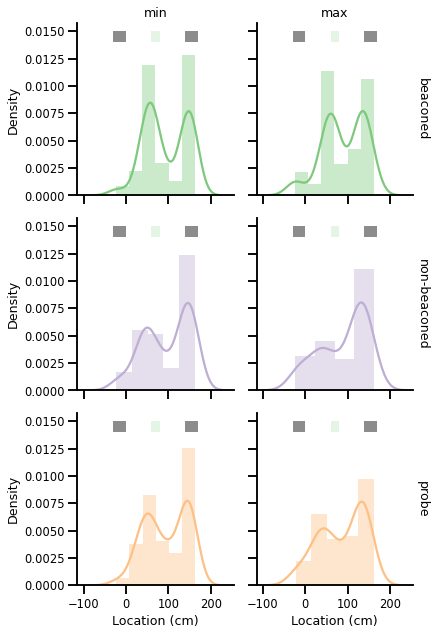

In [14]:
def plotDist_wTrial(*args,**kwargs):
    ax = sns.distplot(*args,**kwargs)
    addTrialStructureBox(ax,0.014,0.015)

# calculate the mean ramp score for shuffled data
sns.set_context('talk',font_scale=0.7)
rs_shuffled = np.abs(dfs_comb.ramp_score[dfs_comb.trial_type=='Shuffled_Rates_averaged'].values)
percentile = np.percentile(rs_shuffled,99)
print(rs_shuffled.max())

# plot the maxima location
dfs2plot = dfs_comb[(dfs_comb.peak_region == 'all') & 
                    (dfs_comb.lm_result_outbound.isin(['Positive','Negative']))]
dfs2plot = dfs2plot[abs(dfs2plot.ramp_score)>rs_shuffled.max()]
dfs2plot['maxima_cm'] -= 30 #shift to fit location definition
g = sns.FacetGrid(dfs2plot, row='trial_type',col='maxima_type',hue='trial_type',margin_titles=True)
g = (g.map(plotDist_wTrial,'maxima_cm',kde=True,hist=True)); #actually should be extrema
[plt.setp(ax.texts, text="") for ax in g.axes.flat] #remove dupliated text
g.set_titles(row_template = '{row_name}',col_template='{col_name}')
g.set_axis_labels(x_var="Location (cm)", y_var='Density')
plt.savefig('paper_figures/S3D.pdf',bbox_inches = "tight")

### Include all cells

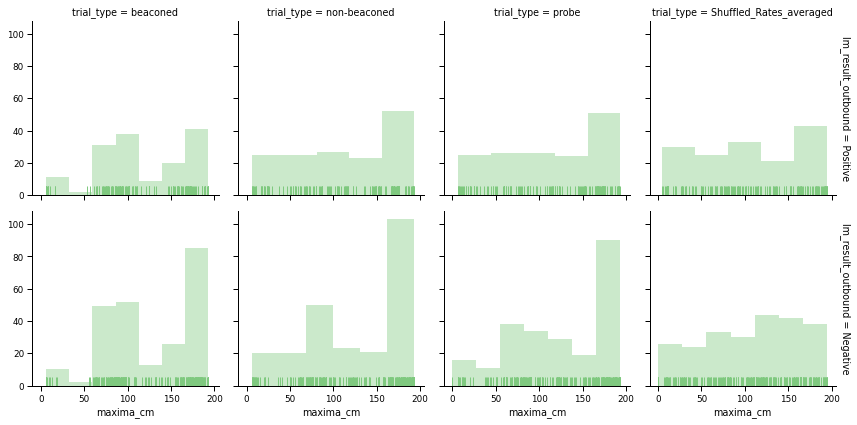

In [7]:
sns.set_context('paper')

# fig,axes = plt.subplots(1,3,figsize=(6*3,4),dpi=300)
dfs2plot = dfs_comb[(dfs_comb.peak_region == 'all') & (dfs_comb.lm_result_outbound.isin(['Positive','Negative']))]
g = sns.FacetGrid(dfs2plot, col='trial_type',row='lm_result_outbound',margin_titles=True)
g = g.map(sns.distplot,'maxima_cm',rug=True,kde=False,hist=True);